In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'figure.figsize': [10,10]})

# 我的滑板車Cartpole (pytorch)

相較於之前學習過的卷積神經網路與遞迴神經網路，強化學習是非常不一樣的，他通常不會有事先整理好成對的輸入特徵與標籤，而是不斷地與外界環境交互，透過交互所累積的獎賞或懲罰來修正行動策略。

<img src="../images/polecart.gif" width="450px">

我們將使用OpenAI's gym CartPole環境模擬器，來教導台車如何平衡上方的木棒。在 CartPole環境中，給定木棒的角度和台車位置及其兩者的變化量，決定讓台車向左或向右來平衡木棒。決策基本上就只有+1(向右)或-1(向左)移動台車，每多保持平衡一刻，就會獎賞+1，當棒子距離垂直角度大於15度或者台車移動距離中心超過2.4單位，則該epoch結束。





**任務目標**

訓練的目的就是希望台車能夠學會正確的移動，好讓木棒持續停留在平衡位置。如果用RL的術語來說，目標就是要找尋正確的 _行動策略_ $a$, 藉由與環境的互動(讓木棒保持平衡)好讓 _獎賞_ $r$ 最大化。於是給定一系列的實驗 $$s \xrightarrow{a} r, s'$$ 讓後讓智能體學會在給定的狀態下 $s$ 找出最佳的行動策略 $a$ 以將跨時間累積獎賞最大化。

行動策略是基於智能體對於未來獎賞的評估，它將會執行帶來最大收益的行動。至於未來獎賞的評估可以用以下方程式表示：

$r$ :

$$
Q(s,a) = r_0 + \gamma r_1 + \gamma^2 r_2 + \ldots = r_0 + \gamma \max_a Q^*(s',a)
$$

此處的 $\gamma \in [0,1)$ 是用來控制評估獎賞的折價因子，我們也稱之為 [*Bellmann*-equation](https://en.wikipedia.org/wiki/Bellman_equation).如果不加入折價因子，智能體將會只看眼前的獎賞，反而可能把自己陷入困境，因此還需要有對未來正確的評估，才能提早執行最佳行動策略。

在接下來的範例中，我們將示範如何針對狀態空間建模，以及如何根據收到的獎賞，來轉化為取得未來最大獎賞的行動。

在此我們將採用強化學習中最經典的技術:

**Deep Q-Networks (DQN)**: DQNs在2015年只透過遊戲畫面像素數據就能訓練智能體玩Atari電動遊戲而聲名大噪。我們訓練神經網路學習 $Q(s,a)$ 值 (也就是 $Q$-Network )。根據這 $Q$ 函數值，我們可以選擇最佳策略。


 

執行實作前需要安裝 OpenAI's [gym](https://github.com/openai/gym)，其中的[CartPole](https://gym.openai.com/envs/CartPole-v0)模擬器中的環境以訓練台車學會維持木棒的平衡。 

In [2]:
try:
    import gym
except:
    !pip install gym

    #你如果想要讓強化學習玩更厲害的遊戲，請去除註解，安裝以下的包
    #!pip install Box2D
    #!pip install gym[atari]
    import gym
    
    

!pip install gym==0.17.2 pyvirtualdisplay==0.2.5



安裝本次實作所需要的包，請注意，trident 0.6以上版本才支援強化學習功能。

In [3]:
import os
import cv2
from copy import deepcopy
from itertools import count
import numpy as np
from collections import namedtuple
import random
import math
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import *
from trident.reinforcement.pytorch_policies import PolicyBase
from trident.models import resnet
from torch.distributions import Bernoulli,Categorical
print(get_plateform())
if get_plateform()=='linux':
    !apt-get install -y xvfb python-opengl x11-utils
    from pyvirtualdisplay import Display
    


trident 0.7.3


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.7.1+cu110.
Automatic Mixed Precision Support:True.


Opencv version:4.1.2.
Pillow version:8.2.0.


windows


## CartPole: 環境與任務定義

由於強化學習是基於與環境的交互進行學習，因此為了有效的學習，需要建構出與真實世界物理狀態一致的模擬環境。這個環境的狀態(state)要能夠被觀察，當智能體執行了行動策略後，這個世界需要根據智能體的行動，反映出行動後續的變化，通常它具有視覺化的畫面，能夠基於交互渲染出對應的結果。在我們這個實作我們首先初始化CartPole的模擬器。

CartPole的狀態共有四個值 $(x, \dot{x}, \theta, \dot{\theta})$, 分別表示 *台車位置*, *台車速度*, *木棒對垂直交角*, *木棒角速度(落下速度)* ，根據以下語法執行結果，你會發現環境一開始的狀態是空的，所有的環境都需要執行env.reset()，才會開始顯示狀態。

In [4]:
#CartPole模擬器
env = gym.make('CartPole-v0').unwrapped

print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

print(env.state)
env.reset()
print(env.state)


Discrete(2)
Box(4,)
[4.8000e+00 3.4028e+38 4.1888e-01 3.4028e+38]
[-4.8000e+00 -3.4028e+38 -4.1888e-01 -3.4028e+38]
None
[-2.0165e-02 -2.5584e-02 2.8379e-02 4.0277e-03]





在每個時間點, 智能體(agent)
 * 取得環境觀察值 (observation_space) $(x, \dot{x}, \theta, \dot{\theta})$, 分別表示 *台車位置*, *台車速度*, *木棒對垂直交角*, *木棒角速度(落下速度)*,
 * 採取行動 (action_space) `向左` 或 `向右`, 以及
 * 獲得
  * 每多存活一刻就會獲得獎賞 +1 
  * 新狀態 $(x', \dot{x}', \theta', \dot{\theta}')$


如果觸發以下條件，則episode終止
 * 木棒距垂直角度大於15度
 * 臺車移動距離中心超過2.4個單位

任務完成認定條件
 * 智能體在過去100個episodes期間平均獎賞值195以上

## DQN

在每次行動執行後 $(s,a,r,s')$, 智能體會更新對於價值函數 $Q(s,a)$ 的預測，而這個Q函數的預測結果應該要與未來獎賞期望值 $r+\gamma \max_{a'}Q(s',a')$ 逼近, 其中 $\gamma$ 是未來獎勵的折扣因子，值介於0和1之間。當兩者越接近，意味著，智能體掌握了決策的Q函數，也就是越能選中正確的行動策略。


DQNs
 * 學習能將觀察 (狀態, 行動)對應至 `score`的 _Q-函數_ 
 * 使用記憶體重放（以前記錄的 $Q$ 值對應不同的 $(s,a)$ 來解相關經驗（序列狀態轉換）


 `ReplayBuffer` 類別是用來儲存不同的狀態、行動以及獎賞，等於是智能體大腦中的記憶體。`智能體`使用`ReplayBuffer`來重放(replay)過去狀態，以選擇能讓獎賞最大化的行動集合，同時也讓訓練與目前執行狀態解耦。請注意，由於為了有較佳學習效果，通常ReplayBuffer的容量會設的較大，所以存入ReplayBuffer的物件都請先轉為numpy格式，而非gpu張量，以避免顯卡容量不足。

In [5]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):
    """ 將先前產生之四元組留存的記憶 """

        
    def __init__(self, capacity):
        """

        Args:
            capacity(int):儲存記憶的最大上限
        
        """
        self.capacity = capacity
        self.memory = []
        self.position = 0



    def push(self, *args):
        """儲存transition."""
        #★trick: 為了節省gpu
        args = [to_numpy(arg) for arg in args]
        
        if len(self.memory) < self.capacity:
            self.memory.append(Transition(*args))
        else:
            self.memory[self.position]=Transition(*args)
        
        #只覆蓋近期數據
        #★trick:為了避免新數據覆蓋舊數據，故意保留錢辦永不覆蓋 
        self.position =int(0.5*self.capacity+(self.position + 1) % (0.5*self.capacity))

    def sample(self, batch_size):
        """查詢先前記憶以構成批次數據"""

        transitions=random_choice(self.memory, batch_size) #named tuple 的清單  [(x1,y1),(x2,y2),(x3,y3)]
        
        #將tuple的清單轉換成清單的tuple  [(x1,y1),(x2,y2),(x3,y3)]==>([x1,x2,x3],[y1,y2,y3])
        items=list(zip(*transitions))
        
        return  Transition(*items)

    def __len__(self):
        return len(self.memory)

### 訓練

我們首先做個簡單的版本，利用gym建置CartPole-v0模擬器環境，使用預設的回傳狀態作為觀察值，其中狀態空間長度為4，行動策略長度為2。  

如何一般的學習過程，我們希望一開始的行動可以較具探索性，然後隨著學習過程逐漸掌握哪些行動比較夠獲得較高報酬，再慢慢降低隨機決策的比例。這種概念的實現稱之為貪婪算法 [epsilon-greedy](https://en.wikipedia.org/wiki/Reinforcement_learning) (a.k.a. $\epsilon$-greedy).   

然後我們就可以遵循以下流程來實現DQN的訓練:  

+ 產生行動決策
+ 根據行動決策產生獎賞
+ 獲取下一個觀察值
+ 將\[觀察值, 行動, 獎賞,下一觀察值\] 四元組儲存
+ 記憶回放更新模型




In [6]:
class DqnPolicy(PolicyBase):
    """The base class for any RL policy.
    """

    def __init__(self, network: Layer, env: gym.Env, memory_length: int = 10000
                 , gamma=0.99, max_epsilon=0.9, min_epsilon=0.01, decay=100
                 , target_update=10,name='dqn') -> None:
        super(DqnPolicy, self).__init__(network=network, env=env, memory_length=memory_length, name=name)

        self.gamma = gamma
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.target_update = target_update
        self.steps_done = 0

    def setting_network(self):
        super()._initial_graph(input_shape=tensor_to_shape(self.get_observation(), need_exclude_batch_axis=True), output=deepcopy(self.network))
        self.policy_net = self.model
        self.policy_net.to(get_device())
        self.policy_net.train()

        self.target_net = copy.deepcopy(self.network)
        self.target_net.to(get_device())
        self.target_net.eval()
        self.summary()

    def get_observation(self):
        # 在這邊維護取得STATE的方法
        #★trick: 別忘記要利用expand_dims產生批次軸
        return np.expand_dims(np.array(list(self.env.state)), 0).astype(np.float32)

    def select_action(self, state,model_only=False, **kwargs):
        # 在這邊維護智能體如何選擇行動的邏輯
        # max_epsilon = 0.9  #初期還沒有案例可以供建模，因此大部分根據隨機案例
        # min_epsilon = 0.01 # 即使模型準確率越來越高，還是必須保留部分比例基於隨機案例
        # decay =200   # 衰減速度

        sample = random.random()
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * math.exp(-1.0 * self.steps_done / self.decay)
        self.steps_done += 1
        if model_only==True or sample > self.epsilon:
            # 原始DQN是根據目標網路選取行動，而double DQN則是在策略網路中選取行動，更新模型時則參考目標網路
            with torch.no_grad():
                selected_action = expand_dims(argmax(self.policy_net(to_tensor(state)), 1),0)
                return selected_action.item()
        else:
            selected_action = np.random.randint(low=0, high=100) % self.env.action_space.n
            return selected_action

    def get_rewards(self, action):
        # 在這邊維護取得獎賞的方法
        # 切換到下一時間點
        observation_, reward, done, info = self.env.step(action)
        
        #★trick: 讓獎賞能夠在快倒之前連續性減分
        x, x_dot, theta, theta_dot = observation_
        #台車位置, 台車速度, 木棒對垂直交角, 木棒角速度(落下速度),
        
        r1 = 0 if abs(x)<0.5* self.env.x_threshold else clip(abs(x)/ self.env.x_threshold,0,1)-0.5
        r2 = 0 if abs(theta)<0.5* self.env.theta_threshold_radians else clip(abs(theta)/ self.env.theta_threshold_radians,0,1)-0.5
        
        #★trick: 倒下時給於懲罰性負分(-3很足夠，設定超大負值只會讓收斂更困難)
        reward = reward - 2*r1 - 2*r2 if not done else -3
        return observation_, reward, done, info 

    def experience_replay(self):
        # 經驗回放
        # 在數據到位時，如何產生獎賞預測值，以及根據次一狀態產生未來獎賞的估計

        batch = self.memory.sample(self.batch_size)

        state_batch = to_tensor(batch.state, requires_grad=True).squeeze(1)
        action_batch = to_tensor(batch.action).long().detach()
        reward_batch = to_tensor(batch.reward).squeeze(1).detach()

        # 基於目前狀態所產生的獎賞期望值預測 Q(s_t)。
        # 策略網路評估行動
        predict_rewards = self.policy_net(state_batch).gather(1, action_batch)

        target_rewards = zeros(len(batch.next_state))
        # 至於未來狀態的部分，未來狀態主要是計算未來價值使用，但是只要是done，等於不再有未來狀態，則要視成功(1)是失敗(-3)來決定獎賞
        for i in range(len(batch.next_state)):
            s = batch.next_state[i]
            # 要計算未來獎賞預估
            if s is not None :
                # 目標網路評估Q值
                self.target_net.eval()
                next_q = self.target_net(to_tensor(s))
                q_next = max(next_q.detach(), axis=1)

                # 計算目標獎賞值(目前實際獎賞+折扣因子]*未來獎賞預估值)
                target_rewards[i] = reward_batch[i] + (q_next * self.gamma)
            # 不再有未來，只有當期獎賞
            else:
                # 如果是最後一筆表示沒有未來價值
                #★trick: 倒了就沒有未來了
                target_rewards[i] = reward_batch[i] + 0

        # 將計算衍生結果以及data_feed暫存於training_context
        train_data = OrderedDict()
        train_data['state'] = state_batch
        train_data['predict_rewards'] = predict_rewards
        train_data['target_rewards'] = expand_dims(target_rewards,1)
        train_data['reward_batch'] = reward_batch
        
        data_feed = OrderedDict()
        data_feed['input'] = 'state'
        data_feed['output'] = 'predict_rewards'
        data_feed['target'] = 'target_rewards'

        self.training_context['data_feed'] = data_feed
        self.training_context['train_data'] = train_data

    def learn(self, num_episodes=300, batch_size=None, print_progess_frequency=10, min_replay_samples=50, repeat_train=16, imshow=True):
        # 智能體學習的主方法
        if batch_size is not None:
            self.batch_size = batch_size

        # 學習一開始將steps_done清零，逐步降低隨機決策比率
        self.steps_done = 0
        train_cnt = 0
        success_cnt = 0
        keep_success_cnt = 0
        start_train_episode = 0
        start_train=False
        #收集初始資料
        while start_train==False:
            # 重置環境
            self.env.reset()
            # 獎賞清零
            total_rewards = 0
            state = self.get_observation()

            for t in count():
                # 基於目前狀態產生行動
                action = self.select_action(state,model_only=False)
                # 基於行動產生獎賞以及判斷是否結束(此時已經更新至下一個時間點)
                observation_, reward, done, info  = self.get_rewards(action)
                    
                # 累積獎賞
                total_rewards += reward

                # 任務完成強制終止(以300為基礎)
                conplete = (not done and t + 1 >= 300)

                if imshow:
                    # 更新視覺化螢幕
                    self.env.render()
                # 取得下一時間點觀察值
                next_state = None if done and not conplete else self.get_observation()

                # 將四元組儲存於記憶中
                self.memory.push(state, action, next_state, reward)
                if  len(self.memory)< min_replay_samples and len(self.memory)%100==0:
                    print("Replay Samples:{0}".format(len(self.memory)))
                    
                if len(self.memory) == min_replay_samples:
                    print('Start Train!!', flush=True)
                    # 需要記憶中的案例數大於批次數才開始訓練
                    start_train = (len(self.memory) >= min_replay_samples)
                    break

                # 切換至下一狀態
                state = copy.deepcopy(next_state)

                if done or conplete:
                    break
        
        #開始訓練模式
        self.training_context['steps'] =0
        self.steps_done=0
        tmp_gamma=0
        
        for i_episode in range(num_episodes):
            current_repeat_train=repeat_train
            for i in range(current_repeat_train):
                
                # 經驗回放獲得訓練用批次數據
                self.output_fn = self.experience_replay

                # 訓練模型
                self.train_model(None, None,
                                 current_epoch=i_episode ,
                                 current_batch=i,
                                 total_epoch=num_episodes,
                                 total_batch=repeat_train,
                                 is_collect_data=True if t>=0 else False ,
                                 is_print_batch_progress=False,
                                 is_print_epoch_progress=False,
                                 log_gradients=False, log_weights=False,
                                 accumulate_grads=False)


            # 定期更新target_net權值
            #★trick: 在每一回合開始前訓練數次，而非每一禎前訓練一次
            if  i_episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict(), strict=True)
                self.save_model(save_path=self.training_context['save_path'])

            # 重置環境
            self.env.reset()
            # 獎賞清零
            total_rewards = 0
            state = self.get_observation()
            tmp_memory=[]

            for t in count():
                # 透過優化器進行一步優化

                # 基於目前狀態產生行動
                action = self.select_action(state,model_only=True)
                # 基於行動產生獎賞以及判斷是否結束(此時已經更新至下一個時間點)
                observation_, reward, done, info  = self.get_rewards(action)
                # 累積獎賞
                total_rewards += reward

                # 任務完成強制終止(以300為基礎)
                #★trick: 因為完成任務是要過去100回合，因此不宜在單次回合耗時過久
                conplete = (not done and t + 1 >= 300)

                if imshow:
                    # 更新視覺化螢幕
                    self.env.render()
                # 取得下一時間點觀察值
                next_state = None if done else self.get_observation()

                # 將四元組儲存於記憶中
                #★trick: 不用全部儲存，儲存有助於改善行動的即可
                if reward<0.5 or random.random()<0.2:
                    self.memory.push(state, action, next_state, reward)
                


                # 切換至下一狀態
                state =next_state
                
                
                if done or conplete:
                    if t + 1 >= 300:
                        keep_success_cnt += 1
                    else:
                        keep_success_cnt = 0
                    #★trick: 連續兩次300分以上則停止更新模型，避免災難性的遺忘
                    if keep_success_cnt >= 2:
                        self.training_context['stop_update']=1
                    else:
                        self.training_context['stop_update']=0


                    # 紀錄累積獎賞
                    self.epoch_metric_history.collect('adj_rewards', i_episode, float(total_rewards))
                    self.epoch_metric_history.collect('rewards', i_episode, float(t+1))
                    steps,values=self.epoch_metric_history.get_series('rewards')
                    score=np.array(values).mean() if i_episode<100 else np.array(values)[-100:].mean()
                    self.epoch_metric_history.collect('score', i_episode, score )
                    
                    
                    # 定期列印學習進度
                    if i_episode > 0 and i_episode  % print_progess_frequency == 0:
                        self.print_epoch_progress(print_progess_frequency)
                    # 定期繪製損失函數以及評估函數對時間的趨勢圖
                    if  i_episode>0 and i_episode  % (5 * print_progess_frequency) == 0:
                        print('negative_reward_ratio:',less(self.training_context['train_data']['reward_batch'],0).mean().item())
                        print('predict_rewards:', self.training_context['train_data']['predict_rewards'].copy()[:5,0])
                        print('target_rewards:', self.training_context['train_data']['target_rewards'].copy()[:5,0])
                        print('reward_batch:', self.training_context['train_data']['reward_batch'].copy()[:5])
                        loss_metric_curve(self.epoch_loss_history, self.epoch_metric_history,metrics_names=list(self.epoch_metric_history.keys()),calculate_base='epoch', imshow=imshow)

                    if i_episode>=100 and score >195:
                        self.save_model(save_path=self.training_context['save_path'])
                        print('episode {0} avg 195 last 100 episodes, training finish! '.format(i_episode))
                        return True

                    break
                

        print('Complete')
        self.env.render()
        self.env.close()
        plt.ioff()
        plt.show()

由於觀察值只有4個數值，因此網路結構不能做的太過複雜，所以都使用全連接層即可，但仔細看我為何不像往常一樣每層都加入Batch Normalization呢?最主要的原因是之後實際推論時每次只會傳入單筆Observation，而非批次，因此 **不使用Batch Normalization以避免日後統計量不一致造成模型表現不穩定**。此外，**最後一層全連接層也不使用活化函數(因為預期的輸出值並非固定值域)**。不少文章建議輸出要正歸化，實際上如果再最後一層加入L2Norm的效果並不好，因為DQN是基於模型模擬出來的Q表來做為決策基準，加了最後一層L2Norm會把決策空間壓扁，反而效果不如預期，如果要加，請加在倒數第二層的位置。

此外，以下是我給的*幾點建議*:
- **所有的機器學習都需要足夠的樣本**，強化學習也不例外。許多坊間的範例，包括pytorch的官方範例，都是當記憶回放儲存了足夠一個批次的樣本就開始學習，這樣做的好處是可以很快就能讓模型獲得達標的獎賞(單次累積獎賞超過200)，但說穿了這就是故意讓模型在有限的樣本中過擬合，但這樣的模型是無法長期以及通用性的達標(連續50次累積獎賞超過200)，而且也因為初始樣本較少，因此很快會因為壞樣本被稀釋造成模型的退化。所以在本次範例中，都是累積樣本數至少在200以上才開始訓練(利用min_replay_samples控制)，這樣時效上雖然慢，但比較能獲得穩定通用的結果。

- 優化器的選擇上請使用**RMSprop優化器**  。

- 強烈建議模型要加入**Dropout**，這可以提升模型的通用性。但是提醒一下，**Dropout絕對不可以加在任何normalization之前**。

- 使用**state中的台車位置, 台車速度,木棒對垂直交角,木棒角速度(落下速度)等數值計算出較為平滑的獎勵機制**，也就是不是僅有掛了的時候才給負分，而是快到失去平衡的過程依據嚴重程度給予漸進式的低分。這麼做等於是基於人類的智能，**將先驗規則以獎勵機制授予了機器**，等於也給予了梯度上的暗示，所以會有不錯的提升效果。

- 挑選一個好的**起始學習速率**真的很重要，建議你可以做幾個不同初始值測試，記得，好的學習速率初始值應該會讓你收斂的過程更為平滑卻陡峭下降。 *

- 強化學習的網路結構不要貪心，**簡單的比較好**，比較容易收斂。  


那有沒有甚麼是我**不建議的行為**呢?
- **不建議使用ReLU**，因為一半是梯度死亡之區，對於訓練強化學習非常不利。 

- **不建議將目標網路更新權值的週期設得太短**，太頻繁的更新權重，會導致當價值網路權值更新後結果目標值其實也變動了，造成無效的擬合，所以不要太頻繁的同步兩者權重。

- 再來是**失去平衡失敗時的懲罰(負的獎勵)也不需要設超級大的負值(我在網上看過有人設成-100)**，因為設定一個很大的負值未必能讓你快速收斂，通常是反效果，而且會造成梯度嚴重波動，反而得很久才能收斂。我個人認為適度就好，當然設成-1不太合理，但是放大失敗時的懲罰還是「適度」就好。


In [7]:
##設計網路結構
network=Sequential(
    Dense(16,auto_pad=True,activation=leaky_relu),
    Dense(32,auto_pad=True,activation=leaky_relu),
    Dropout(0.1),
    Dense(32,auto_pad=True,activation=leaky_relu),
    L2Norm(),
    Dense(env.action_space.n, activation=None)
)

kaiming_normal(network)

#初始化智能體
agent1=DqnPolicy(network,env,gamma=0.99,min_epsilon=0.0001,target_update=10,name='dqn')

--------------------------------------------------------------------------------------------------------------------------------
  Layer (type)    Output Shape               Weight                  Bias      Param #   FLOPS #                  
0  [Dense]        [None, 16]                 'weight', [16, 4]       'bias', [16]  80  158  
1  [Dense]        [None, 32]                 'weight', [32, 16]      'bias', [32]  544  1,086  
2  [Dropout]      [None, 32]                                                   0  0  
3  [Dense]        [None, 32]                 'weight', [32, 32]      'bias', [32]  1,056  2,110  
4  [L2Norm]       [None, 32]                                                   0  0  
5  [Dense]        [None, 2]                  'weight', [2, 32]       'bias', [2]  66  130  
Total params: 1,746
Trainable params: 1,746
Non-trainable params: 0
Total MACC: 1,746
Total FLOPs: 0.00000 GFLOPs
----------------------------------------------------------------
Input size (MB): 0.00
Forw

在trident api中，所謂的強化學習智能體，或者說是策略，其實都是繼承Model而衍生出來的，也因此像是之前我們開始訓練前，需要為Model設定優化器、損失函數、評價函數...等一樣，這些步驟在強化學習來說仍然是一致的，唯一的差別在於在過去我們大多是透過TrainingPlan來定義與執行訓練循環，但是由於強化學習的執行流程本身就是演算法的一部分，不適合分離，也因此它是改為透過learn()這個函數的叫用來觸發學習的演算法流程。

L2Loss( output, target) -> L2Loss 
Replay Samples:100
Start Train!!
dqn          Step: 1m2s     | Loss: 0.220| adj_rewards: 52.383, rewards: 66.900, score: 70.072 | lr: 1.000e-03   ( 10/300 )
dqn          Step: 1m26s    | Loss: 0.187| adj_rewards: 94.908, rewards: 114.400, score: 79.616 | lr: 1.000e-03   ( 20/300 )
dqn          Step: 1m21s    | Loss: 0.164| adj_rewards: 159.292, rewards: 191.700, score: 108.376 | lr: 1.000e-03   ( 30/300 )
dqn          Step: 1m10s    | Loss: 0.152| adj_rewards: 195.953, rewards: 229.900, score: 137.164 | lr: 1.000e-03   ( 40/300 )
dqn          Step: 1m21s    | Loss: 0.144| adj_rewards: 214.932, rewards: 257.000, score: 161.488 | lr: 1.000e-03   ( 50/300 )
negative_reward_ratio: 0.0078125
predict_rewards: tensor([ 0.6278, -0.6735,  4.2782,  2.5075,  5.6016], device='cuda:0',
       grad_fn=<SelectBackward>)
target_rewards: tensor([ 0.0788, -0.3547,  4.0878,  2.8569,  5.7045], device='cuda:0')
reward_batch: tensor([0.3083, 0.1145, 0.2247, 0.9703, 1.0000]

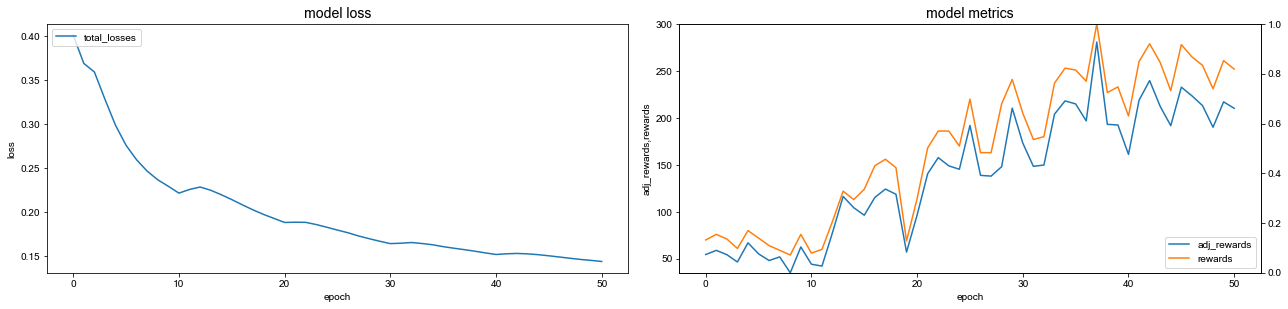

dqn          Step: 1m21s    | Loss: 0.139| adj_rewards: 206.007, rewards: 246.100, score: 177.590 | lr: 1.000e-03   ( 60/300 )
dqn          Step: 56s324ms | Loss: 0.136| adj_rewards: 182.031, rewards: 219.000, score: 184.934 | lr: 1.000e-03   ( 70/300 )
dqn          Step: 2m22s    | Loss: 0.135| adj_rewards: 189.755, rewards: 230.600, score: 190.544 | lr: 1.000e-03   ( 80/300 )
dqn          Step: 1m15s    | Loss: 0.134| adj_rewards: 190.599, rewards: 231.300, score: 195.283 | lr: 1.000e-03   ( 90/300 )
dqn          Step: 58s736ms | Loss: 0.135| adj_rewards: 178.674, rewards: 216.200, score: 198.456 | lr: 1.000e-03   ( 100/300 )
negative_reward_ratio: 0.0
predict_rewards: tensor([ 1.5893, 10.3049,  1.2203,  9.9187,  2.2441], device='cuda:0',
       grad_fn=<SelectBackward>)
target_rewards: tensor([ 1.4115, 10.3998,  1.0104, 10.0978,  1.8192], device='cuda:0')
reward_batch: tensor([0.2516, 1.0000, 0.1921, 1.0000, 0.3214], device='cuda:0')


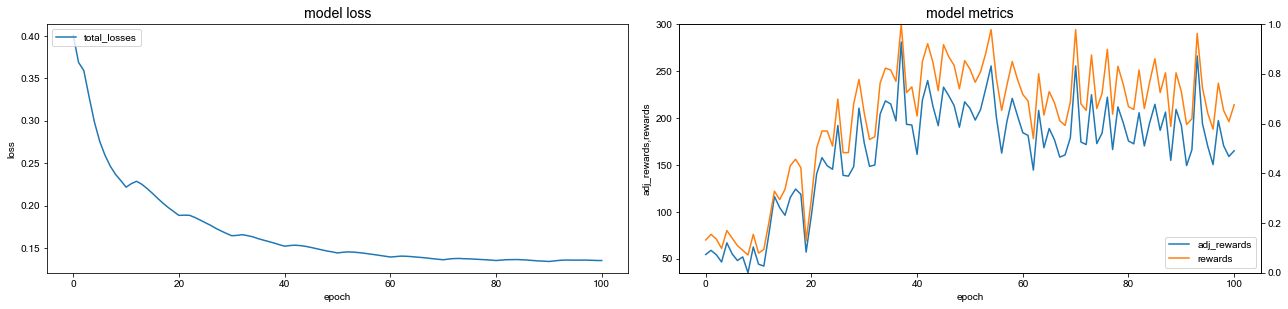

episode 100 avg 195 last 100 episodes, training finish! 


True

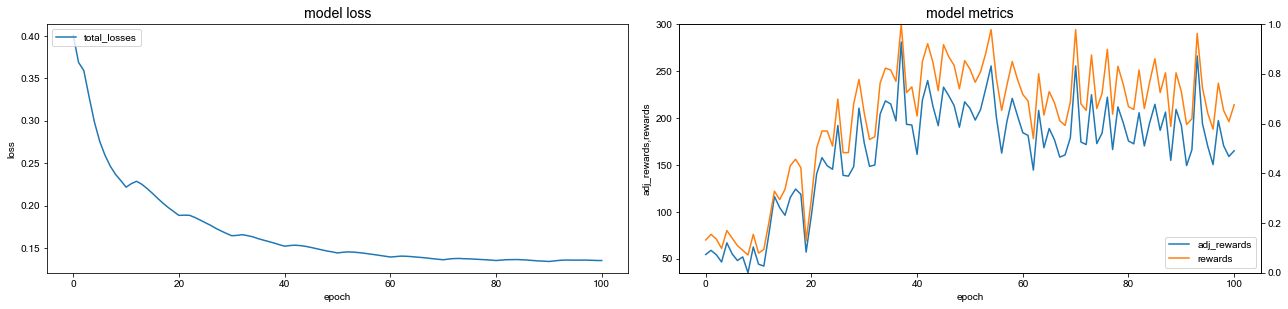

In [8]:

#開始執行學習
agent1.with_optimizer(RMSprop,lr=1e-3)\
    .with_loss(L2Loss)\
    .with_regularizer('l2',reg_weight=1e-5)\
    .with_model_save_path('Models/dqn_dense.pth')\
    .learn(num_episodes=300,batch_size=128,print_progess_frequency=10,repeat_train=30,min_replay_samples=200, imshow=True)


## Policy Gradient 

In [ ]:
import seaborn as sns
def discount_rewards(r, gamma=0.999):
    """使用1D rewards向量以及計算折價後獎賞 """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

discounted_epr = discount_rewards(np.ones(10))
f, ax = plt.subplots(1, figsize=(5,2))
sns.barplot(list(range(10)), discounted_epr, color="steelblue")

In [ ]:
discounted_epr_cent = discounted_epr - np.mean(discounted_epr)
discounted_epr_norm = discounted_epr_cent/np.std(discounted_epr_cent)
f, ax = plt.subplots(1, figsize=(5,2))
sns.barplot(list(range(10)), discounted_epr_norm, color="steelblue")

In [ ]:
discounted_epr_cent = discounted_epr - np.mean(discounted_epr)
discounted_epr_norm = discounted_epr_cent/np.std(discounted_epr_cent)
f, ax = plt.subplots(2, figsize=(5,3))
sns.barplot(list(range(10)), discounted_epr, color="steelblue", ax=ax[0])
sns.barplot(list(range(10)), discounted_epr_norm, color="steelblue", ax=ax[1])

In [ ]:



def plot_duration(episode_durations):
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        plt.pause(0.001)  # pause a bit so that plots are updated

class PolicyGradientPolicy(PolicyBase):
    """The base class for any RL policy.
    """

    def __init__(self, network: Layer, env: gym.Env
                 , gamma=0.99, max_epsilon=0.9, min_epsilon=0.01, decay=100, name='pg') -> None:
        super(PolicyGradientPolicy, self).__init__(network=network, env=env, name=name)

        self.gamma = gamma
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.steps_done = 0
    
    def setting_network(self):
        super()._initial_graph(input_shape=tensor_to_shape(self.get_observation(), need_exclude_batch_axis=True), output=deepcopy(self.network))
        self.policy_net = self.model
        self.policy_net.to(get_device())
        self.policy_net.train()

    def get_observation(self):
        # 在這邊維護取得STATE的方法
        return np.expand_dims(np.array(list(self.env.state)), 0).astype(np.float32)

    def select_action(self, state, model_only=False, **kwargs):
        probs = self.model(state)[0]
        m = Bernoulli(probs)
        action = m.sample()
        return int(action.item())

    def get_rewards(self, action):
        # 在這邊維護取得獎賞的方法
        # 切換到下一時間點
        observation_, reward, done, info = self.env.step(action)
        
        #★trick: 讓獎賞能夠在快倒之前連續性減分
        x, x_dot, theta, theta_dot = observation_
        #台車位置, 台車速度, 木棒對垂直交角, 木棒角速度(落下速度),
        
        r1 = 0 if abs(x) < 0.5 * self.env.x_threshold else clip(abs(x) / self.env.x_threshold, 0, 1) - 0.5
        r2 = 0 if abs(theta) < 0.5 * self.env.theta_threshold_radians else clip(abs(theta) / self.env.theta_threshold_radians, 0, 1) - 0.5

        #★trick: 倒下時給於懲罰性負分(-3很足夠，設定超大負值只會讓收斂更困難)
        reward = reward - 2 * r1 - 2 * r2 if not done else -3

        return observation_, reward, done, info

    def learn(self, num_episodes=1000,batch_size=16,print_progess_frequency=10, imshow=True):
        # 智能體學習的主方法
        # 學習一開始將steps_done清零，逐步降低隨機決策比率
        self.steps_done = 0
        train_cnt = 0
        success_cnt = 0
        keep_success_cnt = 0
        state_pool = []
        action_pool = []
        reward_pool = []

        # 開始訓練
        self.training_context['steps'] = 0
        self.steps_done = 0

        for i_episode in range(num_episodes):
            if i_episode>1:
                batch = self.memory.sample(minimum(batch_size,len(self.memory)))
                for i in range(minimum(batch_size,len(self.memory))):
                    state_pool.extend(batch.state[i])
                    action_pool.extend(batch.action[i])
                    reward_pool.extend(batch.reward[i])
                running_add = 0
                for i in reversed(range(len(reward_pool))):
                    if reward_pool[i] == -3:
                        running_add = -3
                    else:
                        running_add = running_add * self.gamma + reward_pool[i]
                        reward_pool[i] = running_add

                # Normalize reward
                reward_mean = np.mean(reward_pool)
                reward_std = np.std(reward_pool)
                for i in range(len(reward_pool)):
                    reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

                train_data = OrderedDict()
                train_data['state'] = to_tensor(np.array(state_pool))
                train_data['action'] = to_tensor(np.array(action_pool)).float()
                train_data['rewards'] = to_tensor(np.array(reward_pool))
                data_feed = OrderedDict()
                data_feed['input'] = 'state'
                data_feed['output'] = 'output'
                data_feed['action'] = 'action'
                data_feed['rewards'] = 'rewards'

                self.training_context['data_feed'] = data_feed
                self.training_context['train_data'] = train_data

                # 訓練模型
                self.train_model(train_data, None,
                                 current_epoch=i_episode ,
                                 current_batch=0,
                                 total_epoch=num_episodes,
                                 total_batch=1,
                                 is_collect_data=True,
                                 is_print_batch_progress=False,
                                 is_print_epoch_progress=False,
                                 log_gradients=False, log_weights=False,
                                 accumulate_grads=False)
                state_pool = []
                action_pool = []
                reward_pool = []

                if i_episode % print_progess_frequency == 0:
                    self.save_model(save_path=self.training_context['save_path'])

            # 重置環境
            self.env.reset()
            # 獎賞清零
            total_rewards = 0
            state = self.get_observation()

            for t in count():
                # 透過優化器進行一步優化

                # 基於目前狀態產生行動
                action = self.select_action(state, model_only=True)
                # 基於行動產生獎賞以及判斷是否結束(此時已經更新至下一個時間點)
                _, reward, done, info = self.get_rewards(action)
                next_state = self.get_observation()

                # 累積獎賞

                total_rewards += reward
                action_pool.append(float(action))
                state_pool.append(state)
                reward_pool.append(reward)

                # 任務完成強制終止(以300為基礎)
                #★trick: 因為完成任務是要過去100回合，因此不宜在單次回合耗時過久
                conplete = (not done and t + 1 >= 300)


                if imshow:
                    # 更新視覺化螢幕
                    self.env.render()

                #★trick: 標準policy gradient是不做記憶回放的，但我把它修改了一下，改成存放整個序列(因此next state就為None)
                #效果會比傳統policy gradient好很多
                if done or conplete:
                    self.memory.push(state_pool, action_pool,None, reward_pool)
                    state_pool = []
                    action_pool = []
                    reward_pool = []



                    # 判斷是否連續可達300分，如果是則停止學習

                    if t + 1 >= 300:
                        keep_success_cnt += 1

                    else:
                        keep_success_cnt = 0
                    #★trick: 連續兩次300分以上則停止更新模型，避免災難性的遺忘
                    if keep_success_cnt >= 2:
                        self.training_context['stop_update'] = 1
                    else:
                        self.training_context['stop_update'] = 0

                    # 紀錄累積獎賞
                    self.epoch_metric_history.collect('adj_rewards', i_episode, float(total_rewards))
                    self.epoch_metric_history.collect('rewards', i_episode, float(t+1))
                    
                    steps,values=self.epoch_metric_history.get_series('rewards')
                    score=np.array(values).mean()  if i_episode<100 else np.array(values)[-100:].mean()
                    self.epoch_metric_history.collect('score', i_episode, score )
                    

                    # 定期列印學習進度
                    if i_episode > 0 and i_episode  % print_progess_frequency == 0:
                        self.print_epoch_progress(print_progess_frequency)
                    # 定期繪製損失函數以及評估函數對時間的趨勢圖
                    if i_episode > 0 and i_episode % (5 * print_progess_frequency) == 0:
                        loss_metric_curve(self.epoch_loss_history, self.epoch_metric_history,metrics_names=list(self.epoch_metric_history.keys()), calculate_base='epoch', imshow=imshow)

                    if i_episode>=100 and score >195:
                        self.save_model(save_path=self.training_context['save_path'])
                        print('episode {0} avg 195 last 100 episodes, training finish! '.format(i_episode))
                        return True

                    break

                # 切換至下一狀態
                state = next_state


                
        print('Complete')
        self.env.render()
        self.env.close()
        plt.ioff()
        plt.show()



接下來是設計策略網路的ˊ結構，使用全連接層即可，輸出向量長度為1。
請注意: 在使用策略梯度法時,全連接層的輸出要加上sigmoid，以轉換為0~1之間。

In [ ]:

##設計網路結構(注意!!策略梯度的網路結構最後需要加入sigmoid)
network_pg=Sequential(
    Dense(24,auto_pad=True,activation=leaky_relu),
    Dense(36,auto_pad=True,activation=leaky_relu),
    Dense(1, activation=sigmoid)
)

kaiming_normal(network_pg)


#初始化智能體
agent_pg=PolicyGradientPolicy(network_pg,env,gamma=0.99,min_epsilon=0.0001,name='pg')

def pg_loss(output,action,rewards):
    loss=0.0
    for i in range(len(action)):
        probs_i = squeeze(output[i])
        m = Bernoulli(probs_i)
        action_i = torch.FloatTensor([action[i]]).to(get_device())
        reward_i = rewards[i]
        loss += -m.log_prob(action_i) * reward_i  # Negtive score function x reward
    return loss



#開始執行學習
agent_pg.with_optimizer(RMSprop,lr=1e-2)\
    .with_loss(pg_loss)\
    .with_regularizer('l2',reg_weight=1e-5)\
    .with_model_save_path('Models/pg_dense.pth')\
    .learn(num_episodes=10000,batch_size=10,print_progess_frequency=10,imshow=True)